Download the package

In [ ]:
!git clone https://github.com/Gr1Lo/direct.git

Cloning into 'direct'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 217 (delta 33), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (217/217), 2.54 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (85/85), done.


Import functions

In [ ]:
import shutil

shutil.rmtree('/content/direct/')

In [ ]:
import sys
sys.path.insert(0,'/content/direct/scripts')
from utils import find_nearest, CE, RE, direct_statistics
from plots import plot3d, plot2d, plot_clim_train_test
from read_data import rwl2pandas, read_meteo, direct_read, standardize_train, standardize_test, train_test_split
from direct_surface import sq_method, make_surface, predict_on_surface, leave_k_out_plot

Read data

In [ ]:
import pandas as pd
import numpy as np

#====================== meteo-data preparation=====================
clim_df = pd.read_csv('/content/direct/Kluhorskij Pereval/TG_STAID008552.txt',
                      skiprows=19)
clim_df.columns = clim_df.columns.str.replace(' ', '')

#filter by quality code
clim_df = clim_df[clim_df['Q_TG']!=9]

#find mean by months
clim_df['DATE'] = pd.to_datetime(clim_df['DATE'].astype(str), format='%Y%m%d')
clim_df = clim_df.groupby(pd.PeriodIndex(clim_df['DATE'], freq="M"))['TG'].mean()

df = pd.DataFrame(index=np.sort(np.unique(clim_df.index.year)),
                  columns=np.sort(np.unique(clim_df.index.month)))
for i, v in clim_df.items():
  df.at[i.year, i.month]=v

df.to_csv(path_or_buf='/content/direct/Kluhorskij Pereval/TG.txt', sep='\t',
          columns=None, header=False, index=True, na_rep='NaN')
#===========================================================================

#reading meteo and proxy data into single dataframe
proxy_name='BI'
clim_name = 'June–September mean temperature'
mres = direct_read('/content/direct/Kluhorskij Pereval/Cauc_BI_inv.rwl',
              '/content/direct/Kluhorskij Pereval/TG.txt',
              proxy_name=proxy_name,
              clim_name = clim_name,
              meteo_months=[5,6,7,8])

Find best parameters for surface

In [ ]:
#select series with D18 or D09S prefix
D18 = mres.loc[mres["file"].str.startswith(('D18'), na=False)]
D09S =mres.loc[mres["file"].str.startswith(('D09S'), na=False)]
D18_av = D18.groupby('years').mean()
D09S_av = D09S.groupby('years').mean()

#concat two dfs into one with mean adjustment
d = np.mean(D18_av[proxy_name][D18_av.index>=1951])-np.mean(
    D09S_av[proxy_name][D09S_av.index>=1951])
D09S[proxy_name][D09S['years']>1883] =D09S[proxy_name][D09S['years']>1883]+d
mres = pd.concat([D09S,D18])
mres = mres.drop(clim_name,axis=1)

#read df with instrumental data and existing reconsruction
clim_df_e = pd.read_csv('/content/direct/Kluhorskij Pereval/BI rec.csv')
clim_df_e.rename(columns={'year':'years'}, inplace=True)

#merge all dfs
mres = mres.merge(clim_df_e, left_on='years', right_on='years', how='left')
mres.rename(columns={'VI IX instr':clim_name}, inplace=True)

#select data for reconstruction since 1800 year
mres = mres[mres['years']>=1800]

#mask years for train and test dfs
ys =np.sort(np.unique(mres.years))
mask = ~(ys>=1951)
train, test, train_dict = train_test_split(mres, proxy_name,
                                           clim_name, years_mask=mask)

#create dataset for new reconsruction
since1800 = standardize_test(train_dict, mres, proxy_name, clim_name, age_var='age')
since1800 = since1800.drop(since1800[since1800.BI==0].index)

#find best surface parameters
'''metrics = leave_k_out_plot(train,clim_name, proxy_name,n_sq=[10,20,30,40,50],
                           sm=[0.5,1,3,5,10,15],
                           kernel='linear',k=14,
                           Z_shift=True)'''

<ipython-input-19-b3c7acbfa2df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D09S[proxy_name][D09S['years']>1883] =D09S[proxy_name][D09S['years']>1883]+d
<ipython-input-19-b3c7acbfa2df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D09S[proxy_name][D09S['years']>1883] =D09S[proxy_name][D09S['years']>1883]+d


"metrics = leave_k_out_plot(train,clim_name, proxy_name,n_sq=[10,20,30,40,50],\n                           sm=[0.5,1,3,5,10,15],\n                           kernel='linear',k=14,\n                           Z_shift=True)"

Create surface

In [ ]:
sm = 0.5 #smoothing parameter
n_sq = 30 #number of squares in axes for averaging
n = 300 #number of values in axes
uncertainty_data_rep = {
  "part_s": 0.5,
  "n_iter": 1000,
  "alpha":0.05
}
uncertainty_instrumental = {
  "part_s": 0.5,
  "n_iter": 500,
  "alpha":0.05,
  'kernel':'linear',
  'use_squares':True,
  'n' : 300,
  'n_sq' : 50,
  'sm' : 0.5
}


proxy_lim = [min(since1800[proxy_name]), max(since1800[proxy_name])]
age_lim = [min(since1800['age']), max(since1800['age'])]

surface = make_surface(train, train_dict, sm, n_sq, n,
                              proxy_lim = proxy_lim,
                              age_lim = age_lim,
                              kernel='linear',
                              proxy_name=proxy_name,
                              clim_var = clim_name,
                              use_squares=True)

#surface plots
nn = 'n_squares = ' + str(n_sq) + ', smooth = ' + str(sm)
plot2d(train, surface, name_ = nn, proxy_name=proxy_name, clim_name=clim_name)
plot3d(train, surface, proxy_lim, age_lim, name_ = '', proxy_name=proxy_name, clim_name=clim_name)

#make new predictipn
pred_df = predict_on_surface(surface, train_dict, train, test,
           use_std=True, proxy_lim = proxy_lim, age_lim = age_lim,
           proxy_name=proxy_name,
           clim_var = clim_name,
           uncertainty_data_rep = None,
           uncertainty_instrumental = None)

Output hidden; open in https://colab.research.google.com to view.

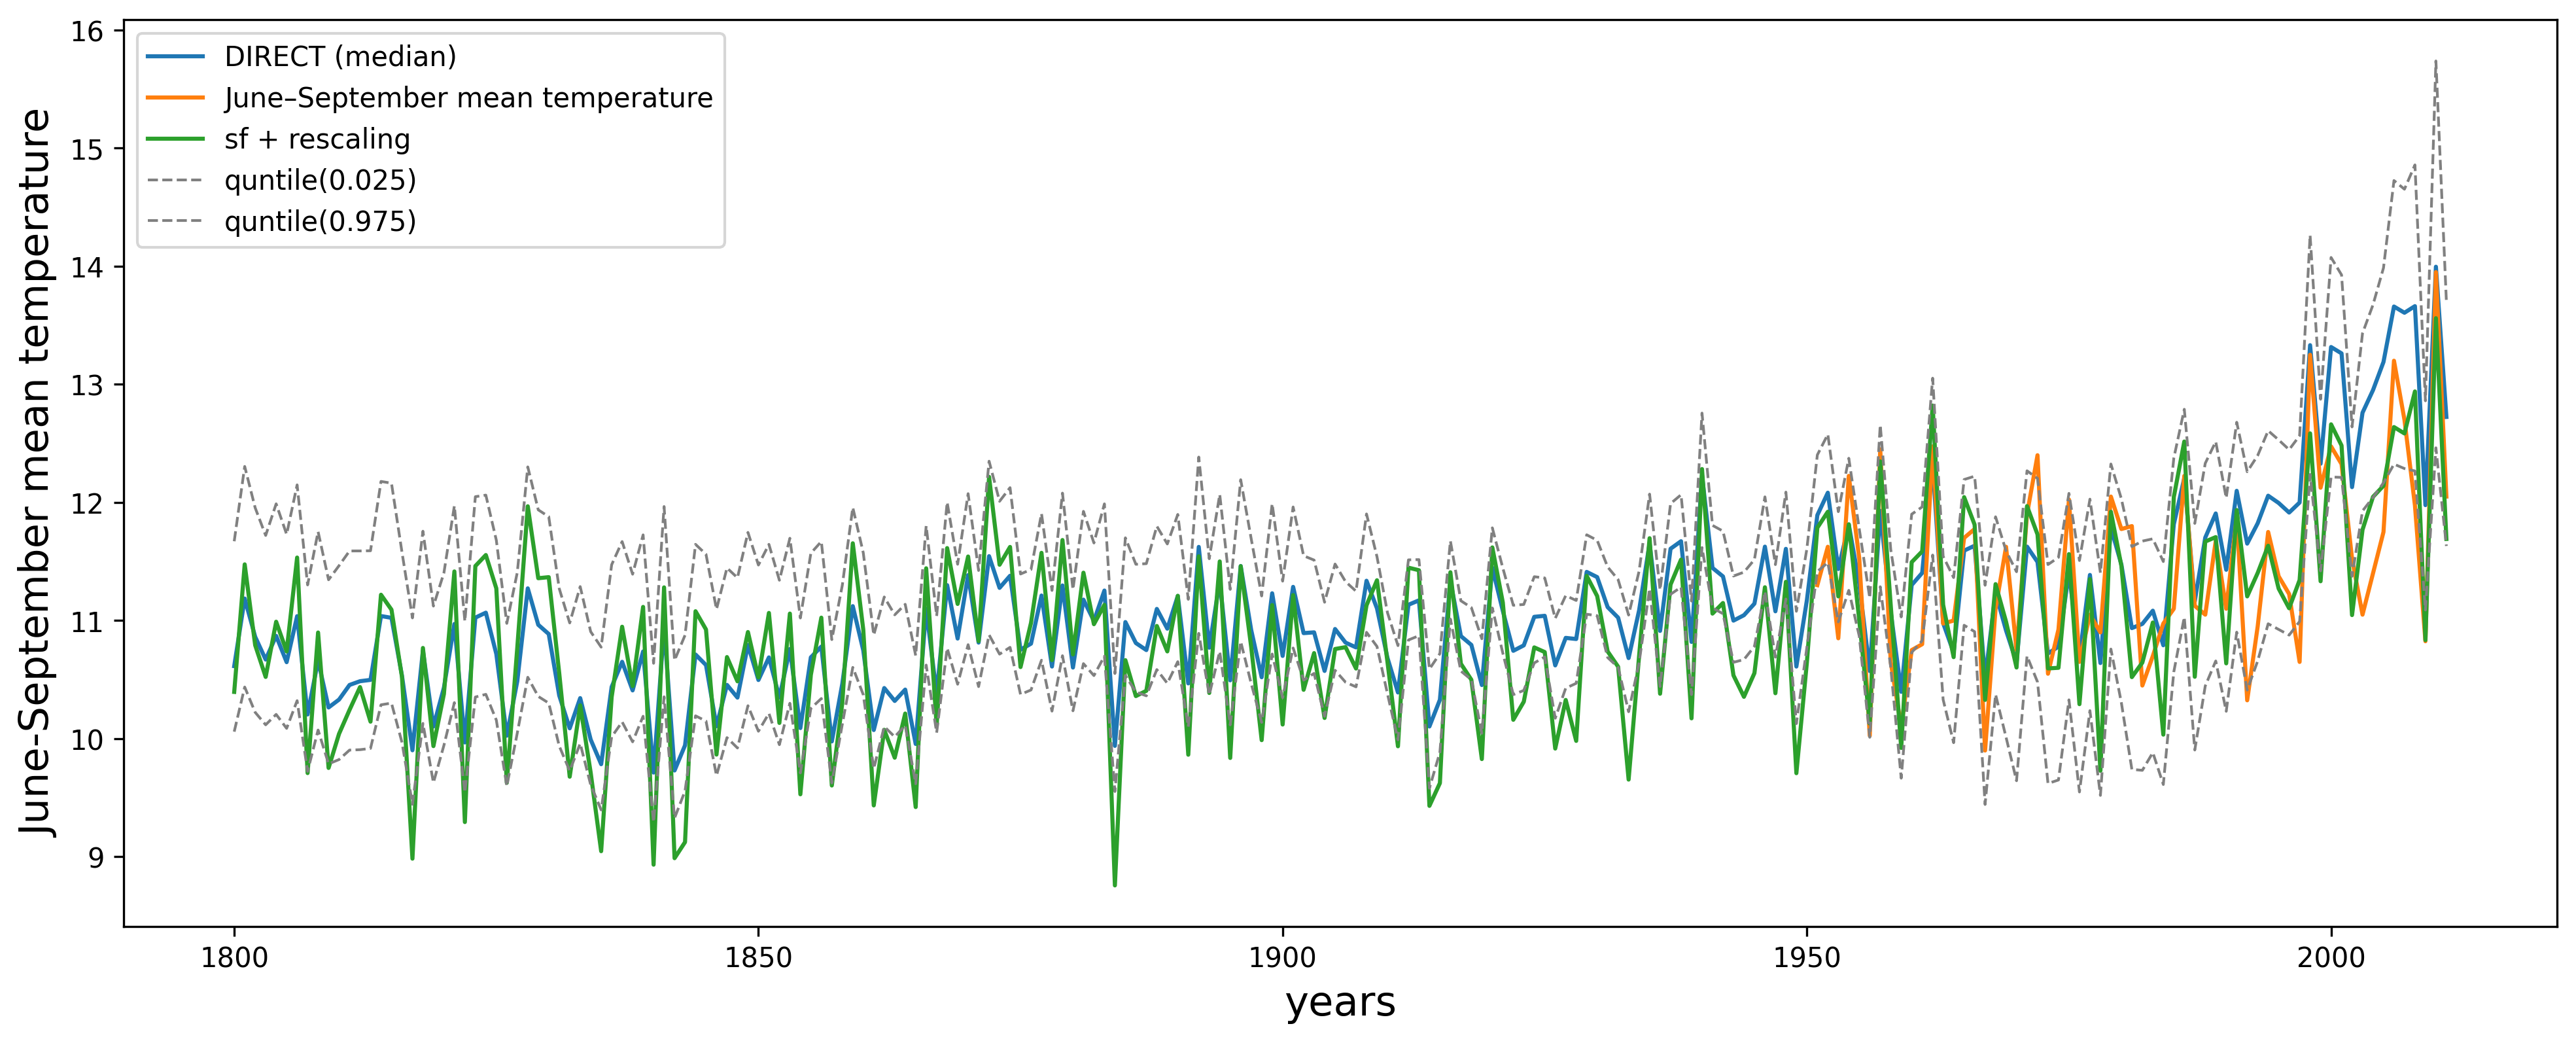

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

plt.plot(pred_df.years, pred_df['median'].values, label = "DIRECT (median)")
plt.plot(pred_df.years, pred_df['June–September mean temperature'].values, label = "June–September mean temperature")
plt.plot(pred_df.years, pred_df['sfc_resc'].values, label = "sf + rescaling")
plt.plot(pred_df.years, pred_df['lower_2'].values, c='gray',lw=1,linestyle='dashed',label = "quntile(0.025)")
plt.plot(pred_df.years, pred_df['upper_2'].values, c='gray',lw=1,linestyle='dashed', label = "quntile(0.975)")
plt.ylabel('June-September mean temperature',fontsize=15)
plt.xlabel('years',fontsize=15)
plt.legend()